# Deep Learning: Project - Venomous/Non-Venomous Snake Detector

Submitted by: [... **Aviv Bar-on** ...]


In [1]:
import tensorflow as tf

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from sklearn.metrics import confusion_matrix
from seaborn import heatmap 
import keras
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG16, vgg16
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

print(tf.__version__)

2.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Initialize:**
Initialize the VGG16 model with adapted find-tuning

In [4]:
tf.compat.v1.disable_eager_execution()

#initialize the model
vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [5]:
# Freeze all the layers
for layer in vgg_model.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa78b5f6b38> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa77b089438> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa77b089978> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa77aff6908> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa77b06ab38> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa77affb588> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa77b009550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa77b009a20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa77b015550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa77b024320> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fa77afb2080> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [6]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
model = keras.Sequential()

# Add the vgg base model
model.add(vgg_model)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid')) # non-linear activition gave better results
model.add(Dropout(0.6))
model.add(Dense(1024, activation='sigmoid')) # non-linear activition gave better results
model.add(Dropout(0.6))
model.add(Dense(1024, activation='sigmoid')) # non-linear activition gave better results
model.add(Dropout(0.5))
# model.add(Dense(256, activation='sigmoid')) # non-linear activition gave better results
# model.add(Dropout(0.7))
model.add(Dense(13, activation='softmax'))

# Show the model summary after adding last layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1

## **Data Processing:**
Loading training and validation data

In [8]:
train_dir = "/content/drive/My Drive/snakes/finaldata/train"

test_dir = "/content/drive/My Drive/snakes/finaldata/test"

data_dir = "/content/drive/My Drive/snakes/finaldata/224"

classes2 = "/content/drive/My Drive/snakes/finaldata/2classes"

CATEGORIES = ["Banded Racer", "Checkered Keelback", "Common Krait", "Common Rat Snake", "Common Sand Boa", "Common Trinket", "Green Tree Vine", "Indian Rock Python", "King Cobra", "Monocled Cobra", "Russell's Viper", "Saw-scaled Viper", "Spectacled Cobra"]

IMG_SIZE = 224

# Process Data Without Augmentation

In [9]:
training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(train_dir,category)  # create path to snakes photos
        class_num = CATEGORIES.index(category)  # get the classification (0-12)

        for img in tqdm(os.listdir(path)):  # iterate over each image per snake
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_training_data()

print(len(training_data))

100%|██████████| 210/210 [00:00<00:00, 366.76it/s]

1463


In [10]:
test_data = []

def create_test_data():
    for category in CATEGORIES:

        path = os.path.join(test_dir,category)  # create path to snakes photos
        class_num = CATEGORIES.index(category)  # get the classification (0-12)

        for img in tqdm(os.listdir(path)):  # iterate over each image per snake
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                test_data.append([new_array, class_num])  # add this to our test_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_test_data()

print(len(test_data))

100%|██████████| 42/42 [00:00<00:00, 357.04it/s]

312


In [11]:
random.shuffle(training_data)
random.shuffle(test_data)

# #split the data to images and classes number

X_train = []
Y_train = []

X_test = []
Y_test = []

for features,label in training_data:
    X_train.append(features)
    Y_train.append(label)

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

#Y_train = np.array(Y_train)
#Y_test = np.array(Y_test)

X_train = np.asarray(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_test = np.asarray(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

## Process Data with Augmentation

In [12]:
# First Augmentation Try

# batch_size = 64

# # prepare data augmentation configuration
# train_datagen = ImageDataGenerator(
#                 rescale = 1./255,
#                 rotation_range=40,
#                 shear_range=0.2,
#                 zoom_range=0.2,
#                 horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#         train_dir,
#         target_size=(IMG_SIZE, IMG_SIZE),
#         batch_size=256,
#         class_mode='sparse')

# validation_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=(IMG_SIZE, IMG_SIZE),
#         batch_size=256,
#         class_mode='sparse')

# # nb_train_samples = X_train.shape[0]
# # nb_validation_samples = X_test.shape[0]

In [13]:
# # Second Augmentation Try

# batch_size = 64

# train_datagen = ImageDataGenerator(rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2) # set validation split

# train_generator = train_datagen.flow_from_directory(
#     data_dir,
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=batch_size,
#     class_mode='sparse',
#     subset='training') # set as training data

# validation_generator = train_datagen.flow_from_directory(
#     data_dir, # same directory as training data
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=batch_size,
#     class_mode='sparse',
#     subset='validation')

## **Compiling the model:**
compile and train the model

In [14]:
# # initialize the model and optimizers
# opt = Adam(lr=0.0006, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# # compile the model with loss function, optimizer and the evaluating metrics
# model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Fit the model based on generator dataset

In [15]:
# history = model.fit(train_generator,                     
#           validation_data=validation_generator,
#           steps_per_epoch=100,
#           epochs=50,
#           validation_steps=50)

Fit the model based on self-processed dataset

In [16]:
# initialize the model and optimizers
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#train the network
history = model.fit(X_train, Y_train,
          batch_size=16, epochs=50,
          validation_data=(X_test, Y_test))

Train on 1463 samples, validate on 312 samples
Epoch 1/50
1463/1463 [==============================] - ETA: 0s - loss: 2.6478 - accuracy: 0.1258WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
1463/1463 [==============================] - 5s 3ms/sample - loss: 2.6478 - accuracy: 0.1258 - val_loss: 2.4526 - val_accuracy: 0.1923
Epoch 2/50
1463/1463 [==============================] - 4s 3ms/sample - loss: 2.5156 - accuracy: 0.1524 - val_loss: 2.2971 - val_accuracy: 0.3205
Epoch 3/50
1463/1463 [==============================] - 4s 3ms/sample - loss: 2.3036 - accuracy: 0.2256 - val_loss: 2.1186 - val_accuracy: 0.3173
Epoch 4/50
1463/1463 [==============================] - 4s 3ms/sample - los

## Confusion Matrix and Graphs

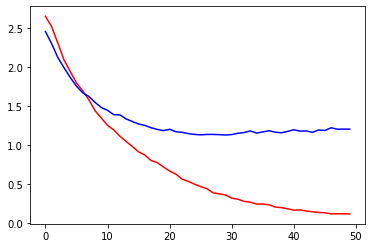

In [17]:
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')

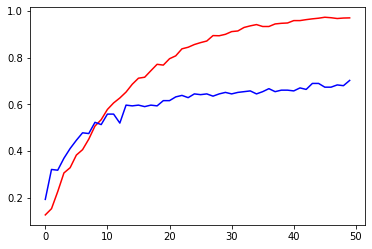

In [18]:
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')

In [19]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
preds = model.predict(X_test)

In [20]:
yhat = np.argmax(preds,axis=1)
cm = confusion_matrix(Y_test, yhat)

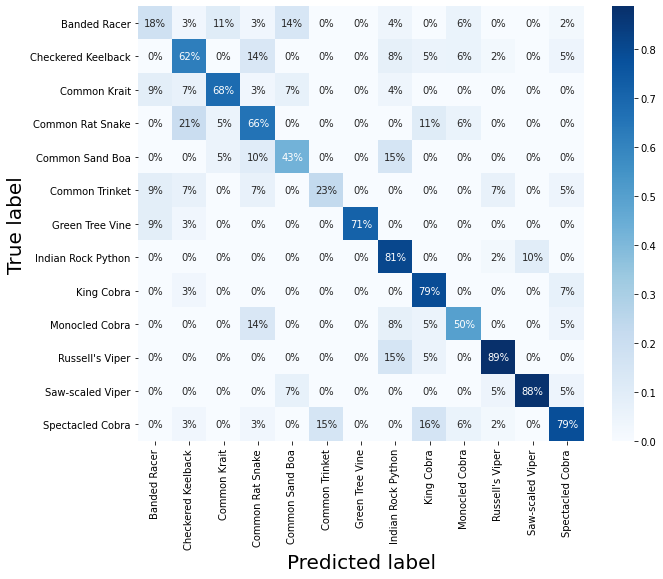

In [21]:
cm = cm / cm.sum(axis=1)

plt.figure(figsize=(10,8))
heatmap(cm,cmap='Blues',annot=True, fmt='.0%', xticklabels=CATEGORIES, yticklabels=CATEGORIES)

plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.show()

In [22]:
# Save the model locally for use later
model_path = os.path.join('/content/drive/My Drive/snakes/trainedmodel',  'trained_VGG_modelPC2.h5')
model.save_weights(os.path.join('/content/drive/My Drive/snakes/trainedmodel','first_tryPC2.h5'))
model.save(model_path)